## KNN Classifier
The model predicts the severity of the landslide (or if there will even be one) within the next 2 days, based on weather data from the past 5 days.
Binary Classification yielded a maximum accuracy of 77.53%. Severity Classification (multiple classes) was around 56%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.utils import shuffle
import pickle

In [2]:
# df = pd.read_csv("full_dataset_v1.csv")
# df = pd.read_csv("/Users/ishaanjavali/Documents/Science Fair/2020/Code/API/full_dataset_v1.csv")
df = pd.read_csv("/Users/ishaanjavali/Documents/Science Fair/2020/Code/API/full_dataset_good.csv")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,6,7,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['severity'].value_counts()

na              4476
medium          3300
small            612
large            426
unknown           75
very_large        56
...                5
landslide          2
catastrophic       1
Name: severity, dtype: int64

In [4]:
# filter by severity. na is for non-landslide data
df = df[df['severity'].isin(["medium", "small", "large", "very_large", "na"])]
# Remove -1 slopes
df = df.loc[~(df.slope == -1)]

In [5]:
df['severity'].value_counts()
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print(len(df))

8696


In [6]:
def getX():
    X = df.copy()

    X.drop(X.columns[[i for i in range(0, 151)]], axis = 1, inplace = True)
    # X.drop(X.columns[[i for i in range(20, 35)]], axis = 1, inplace = True)
    X["severity"] = df["severity"]
    X.drop(X.columns[[0]], axis = 1, inplace = True)

    X = X.dropna()
    for i in range(0, 8):
        del X['air' + str(i)]
        del X['temp' + str(i)]
        del X['humidity' + str(i)]
        
    X.drop(X.columns[[i for i in range(len(X.columns)-8, len(X.columns)-2)]], axis = 1, inplace = True)
    return X
X = getX()
X

,precip7,wind7,precip6,wind6,precip5,wind5,precip4,wind4,precip3,wind3,slope,severity
0,0.0,6,0.0,8,0.0,8,0.1,6,0.7,9,93,medium
1,0.0,11,0.1,10,0.3,14,0.2,14,0.1,17,82,na
2,1.8,9,0.7,10,0.0,9,0.0,12,1.0,16,46,na
3,0.4,9,0.0,9,1.4,12,5.6,21,3.3,24,32,medium
4,1.2,10,11.4,5,6.7,5,5.6,7,1.8,8,43,na
...,...,...,...,...,...,...,...,...,...,...,...,...
8691,2.0,5,1.1,5,0.8,5,2.8,7,0.7,7,8,large
8692,0.0,5,0.5,10,0.9,8,0.0,10,0.7,9,118,na
8693,3.3,10,5.1,6,3.2,10,0.9,9,0.9,10,163,na
8694,0.7,16,4.2,23,0.9,15,0.3,18,0.9,15,22,na


### Generate Labels
For binary classification, pass `True` into the function call

In [7]:
def generate_labels(binary = False):
    global X
    X = getX()
    y = []
    idx_to_severity = ["na", "small", "medium", "large", "very_large"]
    for severity in X.severity:
        if not binary:
            y.append(idx_to_severity.index(severity))
        elif severity == "na":
            y.append(0)
        else:
            y.append(1)
    X.drop(X.columns[[-1]], axis = 1, inplace = True)
    print(y.count(1))
    return y

In [8]:
binary = True
y = generate_labels(binary)

4311


## Scaling

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Prediction

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [11]:
from sklearn.metrics import accuracy_score
pred = knn.predict(X_test)
class_probabilities = knn.predict_proba(X_test)
print("ACCURACY:", accuracy_score(pred, y_test))

ACCURACY: 0.5816091954022988


In [12]:
best = 1
highest = 0

for i in range(1, 130):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    score = round(accuracy_score(pred, y_test)*10000)/100
    print("k =", i, "  ACCURACY:", score)
    if score > highest:
        highest = score
        best = i
# Binary: k = 87, 58.9
# 62.4 na/landslide
print("Best k:", best, highest)

k = 1   ACCURACY: 60.17
k = 2   ACCURACY: 57.41
k = 3   ACCURACY: 58.33
k = 4   ACCURACY: 58.74
k = 5   ACCURACY: 58.39
k = 6   ACCURACY: 57.76
k = 7   ACCURACY: 58.91
k = 8   ACCURACY: 57.13
k = 9   ACCURACY: 58.45
k = 10   ACCURACY: 57.18
k = 11   ACCURACY: 56.61
k = 12   ACCURACY: 56.15
k = 13   ACCURACY: 56.61
k = 14   ACCURACY: 56.21
k = 15   ACCURACY: 56.72
k = 16   ACCURACY: 58.05
k = 17   ACCURACY: 58.16
k = 18   ACCURACY: 57.01
k = 19   ACCURACY: 56.9
k = 20   ACCURACY: 56.49
k = 21   ACCURACY: 57.18
k = 22   ACCURACY: 56.72
k = 23   ACCURACY: 57.13
k = 24   ACCURACY: 56.49
k = 25   ACCURACY: 57.13
k = 26   ACCURACY: 56.44
k = 27   ACCURACY: 55.92
k = 28   ACCURACY: 56.03
k = 29   ACCURACY: 56.15
k = 30   ACCURACY: 56.26
k = 31   ACCURACY: 56.32
k = 32   ACCURACY: 56.9
k = 33   ACCURACY: 56.49
k = 34   ACCURACY: 56.21
k = 35   ACCURACY: 56.26
k = 36   ACCURACY: 55.86
k = 37   ACCURACY: 56.61
k = 38   ACCURACY: 56.03
k = 39   ACCURACY: 56.09
k = 40   ACCURACY: 55.86
k = 41   AC

## Confusion Matrix

In [13]:
knn = KNeighborsClassifier(n_neighbors=87)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
accuracy_score(pred, y_test)

0.5637931034482758

In [14]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, pred)
array

array([[563, 284],
       [475, 418]])

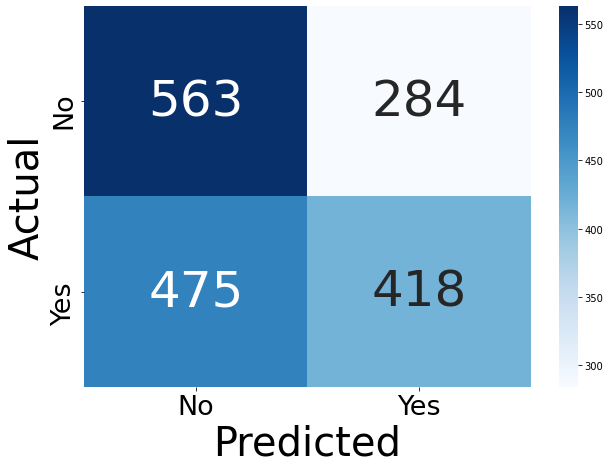

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

if binary:
    df_cm = pd.DataFrame(array, index = [i for i in ["No", "Yes"]],
                    columns = [i for i in ["No", "Yes"]])
else:
    df_cm = pd.DataFrame(array, index = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]],
                  columns = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size":50}, fmt='g')
ax.tick_params(axis='both', which='major', labelsize=27)
plt.xlabel('Predicted', fontsize = 40) 
# plt.title("KNN Confusion Matrix", fontsize = 50)
plt.ylabel('Actual', fontsize = 40) 

plt.show()